In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv("data_revised.csv")

#max view pandas columns
pd.set_option("display.max_columns", None)
df

,FactDt,Customer_number,Business_Volume,Gross_wealth,Net_Wealth,All_Loans,House_free_Equity,Financial_Assets,Investment_Assets,RealEstateValue,HomeLoan,CAR_LOANS,BOAT_LOANS,Other_loans,CustAgeInYears,CustGenderCd,CustEstbDt,fam_members_adult,fam_members,CustMobileLogOnPerMth,CustNetBankLogOnPerMth,IsGeneralMarketingAllowed,IsMarketingForEmailAllowed,IsMarketingForSmsAllowed,IsMarketingForLetterAllowed,IsMarketingForPhoneAllowed,IsMarketingForEbankAllowed,AvgDepositsValueDKK,AvgPensionValueDKK,AvgHomeFinanceValueDKK,AvgOtherLoansValueDKK,AvgInvestmentsValueDKK,Deposits_Cards_lowest,Deposits_ordinary_lowest,Creditcard_overdraft_lowest,All_Loans_Positive,NetWealth_pct_change,NetWealth_pct_change_forward,NetWealth_abs_change,NetWealth_abs_change_forward,extreme_jump,age_diff
0,2022-01-31,00000D5121B9B74EC7339DF502AD5D13,74537.84,74537.84,74141.75,-396.09,0.00,14089.25,60448.59,0.0,0.00,0.0,0.0,-396.09,59.0,F,1986-01-01,2,2,15,1,1,0,0,0,0,0,0.00,59841.95,0.00,0.0,15876,-6955.24,-6955.24,0.0,396.09,NaN,0.040448,NaN,2882.28,False,NaN
1,2022-02-28,00000D5121B9B74EC7339DF502AD5D13,71646.83,71646.83,71259.47,-387.36,0.00,14089.25,57557.58,0.0,0.00,0.0,0.0,-387.36,59.0,F,1986-01-01,2,2,18,0,1,0,0,0,0,0,0.00,59841.95,0.00,0.0,16077,-871.99,-871.99,0.0,387.36,-0.038875,-0.014160,-2882.28,-1023.54,False,0.0
2,2022-03-31,00000D5121B9B74EC7339DF502AD5D13,72638.84,72638.84,72283.01,-355.83,0.00,14345.25,58293.59,0.0,0.00,0.0,0.0,-355.83,59.0,F,1986-01-01,2,2,15,0,1,0,0,0,0,0,0.00,59924.53,0.00,0.0,14125,-863.27,-863.27,0.0,355.83,0.014364,0.015802,1023.54,1124.44,False,0.0
3,2022-04-30,00000D5121B9B74EC7339DF502AD5D13,71461.08,71461.08,71158.57,-302.51,0.00,14345.25,57115.83,0.0,0.00,0.0,0.0,-302.51,59.0,F,1986-01-01,2,2,12,0,1,0,0,0,0,0,0.00,60097.95,0.00,0.0,14809,-302.51,-302.51,0.0,302.51,-0.015556,0.004722,-1124.44,334.46,False,0.0
4,2022-05-31,00000D5121B9B74EC7339DF502AD5D13,71148.01,71148.01,70824.11,-323.90,0.00,14345.25,56802.76,0.0,0.00,0.0,0.0,-323.90,60.0,F,1986-01-01,2,2,12,0,1,0,0,0,0,0,0.00,60097.95,0.00,0.0,13896,-750.53,-750.53,0.0,323.90,-0.004700,0.049437,-334.46,3336.38,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,2022-07-31,0174CFCBED87171B4F6A651734F836E4,1957353.73,4364667.34,2971980.95,-1392686.39,2407313.61,564667.34,0.00,3800000.0,-1392686.39,0.0,0.0,0.00,61.0,M,1997-01-25,2,2,0,1,1,0,0,0,0,0,543163.49,0.00,-1467887.13,0.0,0,526440.22,526440.22,0.0,1392686.39,-0.011776,-0.025747,-35415.67,-78540.79,False,0.0
119996,2022-08-31,0174CFCBED87171B4F6A651734F836E4,1871228.88,4360875.31,3050521.74,-1310353.57,2489646.43,560875.31,0.00,3800000.0,-1310353.57,0.0,0.0,0.00,61.0,M,1997-01-25,2,2,0,1,1,0,0,0,0,0,547337.46,0.00,-1459888.70,0.0,0,529276.56,529276.56,0.0,1310353.57,0.026427,-0.033473,78540.79,-105646.97,False,0.0
119997,2022-09-30,0174CFCBED87171B4F6A651734F836E4,1782110.97,4369139.84,3156168.71,-1212971.13,2587028.87,569139.84,0.00,3800000.0,-1212971.13,0.0,0.0,0.00,61.0,M,1997-01-25,2,2,0,1,1,0,0,0,0,0,556859.26,0.00,-1450376.58,0.0,0,541477.36,541477.36,0.0,1212971.13,0.034632,0.017323,105646.97,53744.42,False,0.0
119998,2022-10-31,0174CFCBED87171B4F6A651734F836E4,1854847.71,4378636.00,3102424.29,-1276211.71,2523788.29,578636.00,0.00,3800000.0,-1276211.71,0.0,0.0,0.00,61.0,M,1997-01-25,2,2,0,2,1,0,0,0,0,0,564236.98,0.00,-1443871.51,0.0,0,548696.11,548696.11,0.0,1276211.71,-0.017028,0.011693,-53744.42,35858.32,False,0.0


In [3]:

df = df.sort_values(["Customer_number", "FactDt"])


inv = df["Investment_Assets"]

# Did customer have investments already in first observed month?
first_month_has_inv = (
    df.assign(inv=inv)
      .groupby("Customer_number")["inv"]
      .transform("first") > 0
)

# Any month after the first where Investment_Assets > 0?
ever_inv_after_first = (
    df.assign(inv=inv)
      .groupby("Customer_number")["inv"]
      .transform(lambda s: (s.iloc[1:] > 0).any() if len(s) > 1 else False)
)

# Customer-level first-time investor flag (broadcast to rows)
df["first_time_investor"] = (ever_inv_after_first & ~first_month_has_inv).astype(int)


In [4]:

#look at snapchat, latest observation:
latest = df.groupby("Customer_number").tail(1).copy()


# "Ever" flags across the year (holdings/loan presence)
ever = df.groupby("Customer_number").agg(
    has_investments=("Investment_Assets", lambda s: (s.fillna(0) > 0).any()),
    has_homeloan=("HomeLoan", lambda s: (s.fillna(0) < 0).any()),
    has_carloan=("CAR_LOANS", lambda s: (s.fillna(0) < 0).any()),
).reset_index()

cust = latest.merge(ever, on="Customer_number", how="left")

cluster_df = cust[[
    "Customer_number",
    "has_investments",
    "Net_Wealth",
    "has_homeloan",
    "has_carloan",
    "CustAgeInYears",
    "CustGenderCd",
    "fam_members",
    "fam_members_adult",
    "first_time_investor"
]].copy()


# Convert booleans to 0/1
for c in ["has_investments", "has_homeloan", "has_carloan", "first_time_investor"]:
    cluster_df[c] = cluster_df[c].astype(int)


# Log transform (protect against negatives by clipping at 0 first)
cluster_df["Net_Wealth_log"] = np.log1p(cluster_df["Net_Wealth"].clip(lower=0))

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

features = [
    "has_investments",
    "Net_Wealth",
    "has_homeloan",
    "has_carloan",
    "CustAgeInYears",
    "CustGenderCd",
    "fam_members",
    "fam_members_adult"
]

X = cluster_df[features].copy()

numeric_features = ["Net_Wealth", "CustAgeInYears", "fam_members", "fam_members_adult"]
binary_features  = ["has_investments", "has_homeloan", "has_carloan"]
categorical_features = ["CustGenderCd"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features),
        ("bin", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent"))
        ]), binary_features),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features),
    ],
    remainder="drop"
)

# Pick K by silhouette (simple, interview-friendly)
best_k, best_score = None, -1
for k in range(3, 9):
    pipe = Pipeline([
        ("prep", preprocess),
        ("kmeans", KMeans(n_clusters=k, random_state=42, n_init="auto"))
    ])
    labels = pipe.fit_predict(X)
    score = silhouette_score(pipe.named_steps["prep"].transform(X), labels)
    print(f"k={k} silhouette={score:.3f}")
    if score > best_score:
        best_k, best_score = k, score

print("Best k:", best_k, "Best silhouette:", round(best_score, 3))

# Fit final model with best k
final_pipe = Pipeline([
    ("prep", preprocess),
    ("kmeans", KMeans(n_clusters=best_k, random_state=42, n_init="auto"))
])

cluster_df["cluster"] = final_pipe.fit_predict(X)

k=3 silhouette=0.265
k=4 silhouette=0.252
k=5 silhouette=0.312
k=6 silhouette=0.296
k=7 silhouette=0.286
k=8 silhouette=0.308
Best k: 5 Best silhouette: 0.312


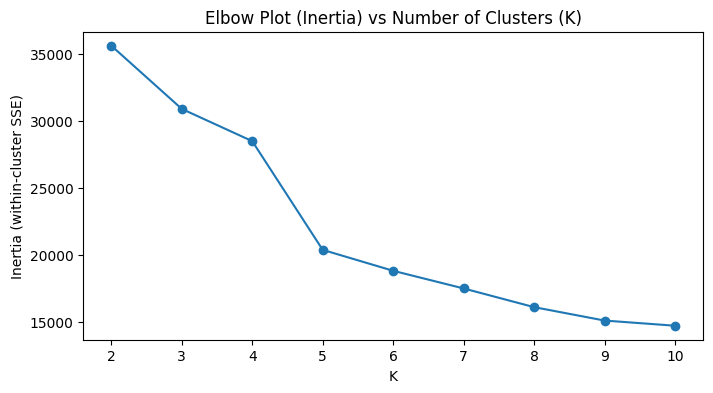

In [6]:
Ks = list(range(2, 11))
sil_scores = []
inertias = []

for k in Ks:
    pipe = Pipeline([
        ("prep", preprocess),
        ("kmeans", KMeans(n_clusters=k, random_state=42, n_init="auto"))
    ])
    labels = pipe.fit_predict(X)
    Xp = pipe.named_steps["prep"].transform(X)

    sil_scores.append(silhouette_score(Xp, labels))
    inertias.append(pipe.named_steps["kmeans"].inertia_)

# --- Elbow (inertia) plot ---
plt.figure(figsize=(8, 4))
plt.plot(Ks, inertias, marker="o")
plt.title("Elbow Plot (Inertia) vs Number of Clusters (K)")
plt.xlabel("K")
plt.ylabel("Inertia (within-cluster SSE)")
plt.xticks(Ks)
plt.show()

In [7]:

#display all columns pandas
pd.set_option('display.max_columns', None)

#display not in scientific form, and at max 2 decimals, use "," as the decimal and "." as thousand seperator
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x).replace(',', 'X').replace('.', ',').replace('X', '.'))

profile = cluster_df.groupby("cluster").agg(
    customers=("Customer_number", "nunique"),
    share_investors=("has_investments", "mean"),
    share_homeloan=("has_homeloan", "mean"),
    share_carloan=("has_carloan", "mean"),
    avg_net_wealth=("Net_Wealth", "mean"),
    median_net_wealth=("Net_Wealth", "median"),
    avg_age=("CustAgeInYears", "mean"),
    avg_fam=("fam_members", "mean"),
    avg_adults=("fam_members_adult", "mean"),
    share_first_time_investor=("first_time_investor", "mean")
).sort_values("customers", ascending=False)

# Gender shares per cluster (adjust if your gender coding isn't 'M'/'F')
gender_shares = (
    cluster_df.groupby("cluster")["CustGenderCd"]
      .value_counts(normalize=True)
      .unstack(fill_value=0)
)

# Add share of M (and others if present)
if "M" in gender_shares.columns:
    profile["share_M"] = gender_shares["M"]
else:
    profile["share_M"] = 0  # in case 'M' isn't used in your coding

# Optional: include share_F too if it exists
if "F" in gender_shares.columns:
    profile["share_F"] = gender_shares["F"]

# Sort + display
profile = profile.sort_values("customers", ascending=False)


profile

,customers,share_investors,share_homeloan,share_carloan,avg_net_wealth,median_net_wealth,avg_age,avg_fam,avg_adults,share_first_time_investor,share_M,share_F
cluster,,,,,,,,,,,,
2,3133,"0,16","0,03","0,00","81.755,59","13.955,25","27,23","1,19","0,96","0,01","0,57","0,43"
0,3082,"0,41","0,45","0,03","743.824,92","375.524,84","58,38","2,10","2,00","0,01","0,51","0,49"
1,2453,"0,35","0,21","0,01","534.003,32","88.574,72","64,57","1,04","0,99","0,01","0,43","0,57"
4,1441,"0,31","0,27","0,03","424.283,05","31.196,94","23,58","3,98","1,97","0,01","0,49","0,51"
3,342,"0,84","0,82","0,01","6.423.935,10","5.244.311,46","63,96","1,82","1,58","0,01","0,63","0,37"


In [ ]:
#cannot see real difference in first time investor


In [8]:
cluster_df = cust[[
    "Customer_number",
    "Net_Wealth",
    "CustAgeInYears",
    "CustGenderCd",
    "fam_members",
    "fam_members_adult",
    "has_investments",
    "has_homeloan",
    "has_carloan",
    "first_time_investor",
]].copy()

# Booleans -> 0/1
for c in ["has_investments", "has_homeloan", "has_carloan", "first_time_investor"]:
    cluster_df[c] = cluster_df[c].astype(int)



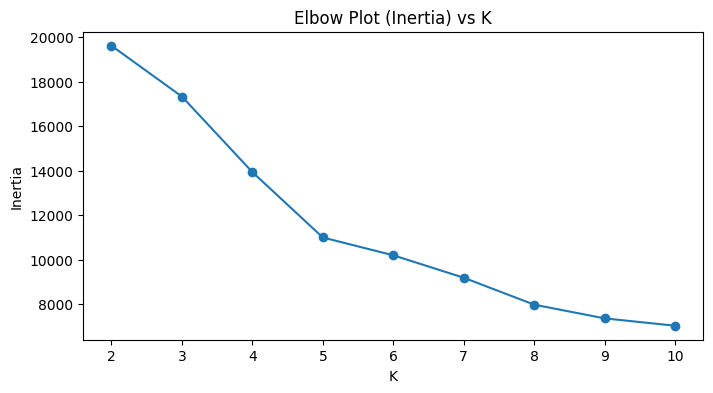

Best K by silhouette: 2 score: 0.359


,customers,share_first_time_investor,share_homeloan,share_carloan,avg_net_wealth,median_net_wealth,avg_age,avg_fam,avg_adults,share_M,share_F
cluster,,,,,,,,,,,
3,1936,"0,02","0,03","0,00","105.210,49","16.733,00","28,39","1,08","0,98","0,53","0,46"
2,1543,"0,02","0,41","0,03","592.214,63","173.464,33","58,57","2,04","2,00","0,49","0,51"
1,1312,"0,01","0,23","0,00","484.090,15","52.940,93","66,00","1,03","0,99","0,42","0,58"
4,1007,"0,00","0,03","0,01","-10.318,70","0,00","44,72","1,31","1,23","0,59","0,41"
0,654,"0,02","0,40","0,04","459.347,93","49.418,71","35,82","3,75","1,96","0,40","0,60"


In [9]:
# ------------------------------------------------------------
# 0) Filter OUT "already investors" group before clustering
#     Remove: (has_investments == 1) & (first_time_investor == 0)
# ------------------------------------------------------------
cluster_df_filtered = cluster_df[
    ~((cluster_df["has_investments"] == 1) & (cluster_df["first_time_investor"] == 0)) & (cluster_df['CustAgeInYears']>=15)
].copy()

# ------------------------------------------------------------
# 1) Feature engineering for clustering
# ------------------------------------------------------------
# Log wealth (clip at 0 in case of negative net wealth)
cluster_df_filtered["Net_Wealth_log"] = np.log1p(cluster_df_filtered["Net_Wealth"].clip(lower=0))

# ------------------------------------------------------------
# 2) KMeans with proper preprocessing (mixed data)
# ------------------------------------------------------------
features = [
    "first_time_investor",
    "Net_Wealth_log",
    "has_homeloan",
    "has_carloan",
    "CustAgeInYears",
    "CustGenderCd",
    "fam_members",
    "fam_members_adult",
]

X = cluster_df_filtered[features].copy()

numeric_features = ["Net_Wealth_log", "CustAgeInYears", "fam_members", "fam_members_adult"]
binary_features  = ["first_time_investor",  "has_homeloan", "has_carloan"]
categorical_features = ["CustGenderCd"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features),
        ("bin", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent"))
        ]), binary_features),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features),
    ],
    remainder="drop"
)

# ------------------------------------------------------------
# 3) Choose K (silhouette + inertia plots)
# ------------------------------------------------------------
Ks = list(range(2, 11))
sil_scores = []
inertias = []

for k in Ks:
    pipe = Pipeline([
        ("prep", preprocess),
        ("kmeans", KMeans(n_clusters=k, random_state=42, n_init="auto"))
    ])
    labels = pipe.fit_predict(X)
    Xp = pipe.named_steps["prep"].transform(X)

    sil_scores.append(silhouette_score(Xp, labels))
    inertias.append(pipe.named_steps["kmeans"].inertia_)

# Elbow plot (inertia)
plt.figure(figsize=(8, 4))
plt.plot(Ks, inertias, marker="o")
plt.title("Elbow Plot (Inertia) vs K")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.xticks(Ks)
plt.show()

best_k = Ks[int(np.argmax(sil_scores))]
print("Best K by silhouette:", best_k, "score:", round(max(sil_scores), 3))

# ------------------------------------------------------------
# 4) Fit final model on filtered dataset
# ------------------------------------------------------------


Overwrite_k=5
final_pipe = Pipeline([
    ("prep", preprocess),
    ("kmeans", KMeans(n_clusters=Overwrite_k, random_state=42, n_init="auto"))
])

cluster_df_filtered["cluster"] = final_pipe.fit_predict(X)

# ------------------------------------------------------------
# 5) Profile clusters (include share_M + share_F if present)
# ------------------------------------------------------------
profile = cluster_df_filtered.groupby("cluster").agg(
    customers=("Customer_number", "nunique"),
    share_first_time_investor=("first_time_investor", "mean"),
    share_homeloan=("has_homeloan", "mean"),
    share_carloan=("has_carloan", "mean"),
    avg_net_wealth=("Net_Wealth", "mean"),
    median_net_wealth=("Net_Wealth", "median"),
    avg_age=("CustAgeInYears", "mean"),
    avg_fam=("fam_members", "mean"),
    avg_adults=("fam_members_adult", "mean"),
)

gender_shares = (
    cluster_df_filtered.groupby("cluster")["CustGenderCd"]
      .value_counts(normalize=True)
      .unstack(fill_value=0)
)

profile["share_M"] = gender_shares["M"] if "M" in gender_shares.columns else 0
if "F" in gender_shares.columns:
    profile["share_F"] = gender_shares["F"]

profile = profile.sort_values("customers", ascending=False)
display(profile)